# Global

- Area : Biological Sciences
- Start : jan-1856
- Finish : dec-2005
- Stationary : No
- m : 1800

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import BayesianRidge
from sklearn.svm import LinearSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error

sys.path.append("../utils/")
from data import load_dataset
from plot import plot, plot_stl, acf, plot_predictions
from forecasting import Naive, SeasonalNaive, TimeSeriesForecaster
from metrics import pocid, multi_criteria

## Training data

In [2]:
data = load_dataset(9)
period = 12
detrend = True

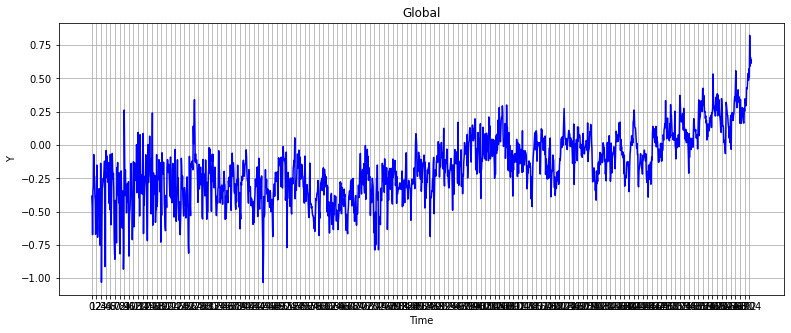

In [3]:
plot(data[0], 'Global')

## STL decomposition

<ipython-input-4-89dfef313495>:1: RuntimeWarning: invalid value encountered in log1p
  res = plot_stl(np.log1p(data[0]))


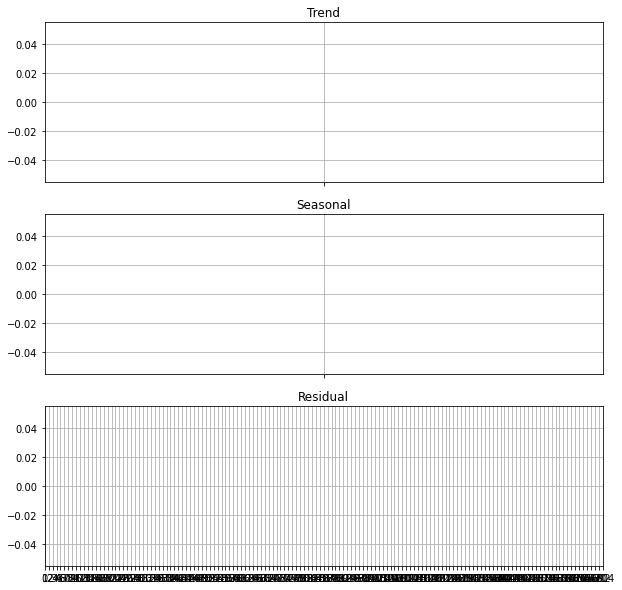

In [4]:
res = plot_stl(np.log1p(data[0]))

## L-Jung Box test

In [5]:
acorr_ljungbox(res.resid, period=period, return_df=True)

,lb_stat,lb_pvalue
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN
10,NaN,NaN


## Residuals Auto Correlation

/home/gabriel/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


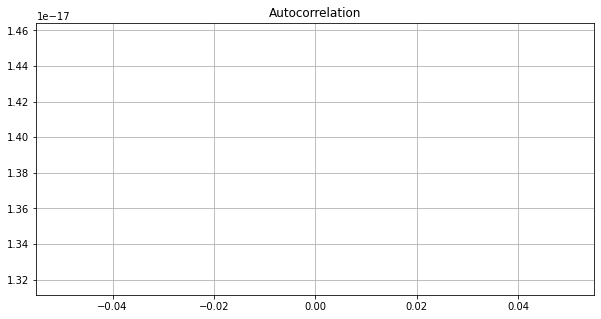

In [6]:
acf(res.resid)

## Baseline Training (Naive and Seasonal Naive)

In [7]:
naive = Naive()
naive.fit(data[0])
y_naive = naive.predict(len(data[1]))

snaive = SeasonalNaive(period=period)
snaive.fit(data[0])
y_snaive = snaive.predict(len(data[1]))

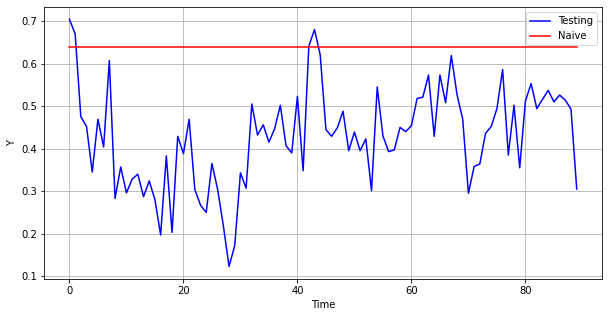

In [8]:
plot_predictions(data[1], y_naive, "Naive")

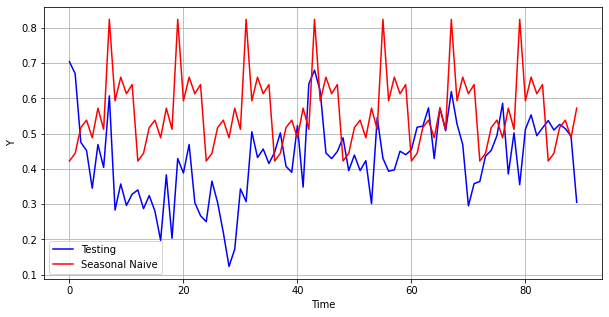

In [9]:
plot_predictions(data[1], y_snaive, "Seasonal Naive")

## Bayesian Ridge Regression

In [10]:
br = TimeSeriesForecaster(BayesianRidge(), window_length=period, detrend=detrend)
br.fit(data[0])
y_br = br.predict(len(data[1]))

sbr = TimeSeriesForecaster(BayesianRidge(), window_length=period, detrend=detrend, period=period)
sbr.fit(data[0])
y_sbr = sbr.predict(len(data[1]))

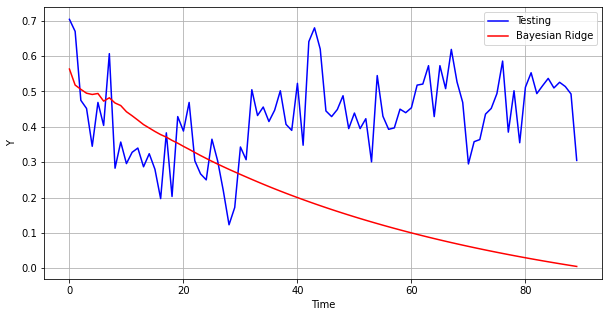

In [11]:
plot_predictions(data[1], y_br, "Bayesian Ridge")

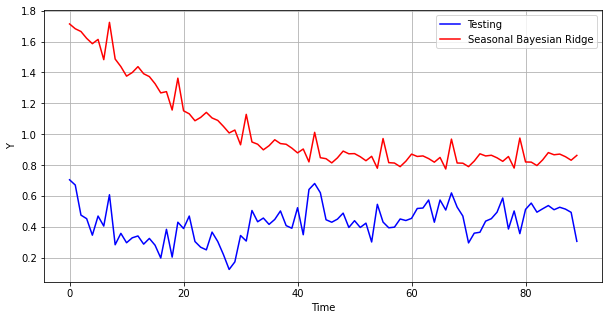

In [12]:
plot_predictions(data[1], y_sbr, "Seasonal Bayesian Ridge")

## Kernel Ridge

In [13]:
kr = TimeSeriesForecaster(KernelRidge(kernel="rbf"), window_length=period, detrend=detrend)
kr.fit(data[0])
y_kr = kr.predict(len(data[1]))

skr = TimeSeriesForecaster(KernelRidge(kernel="rbf"), window_length=period, detrend=detrend, period=period)
skr.fit(data[0])
y_skr = skr.predict(len(data[1]))

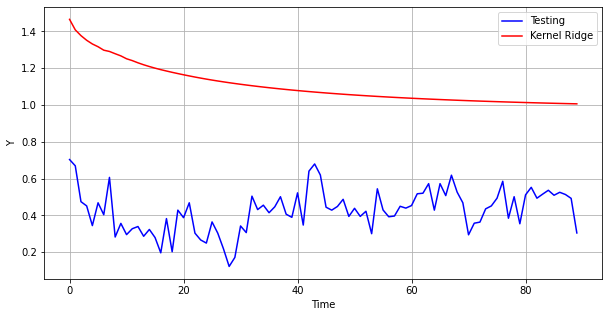

In [14]:
plot_predictions(data[1], y_kr, "Kernel Ridge")

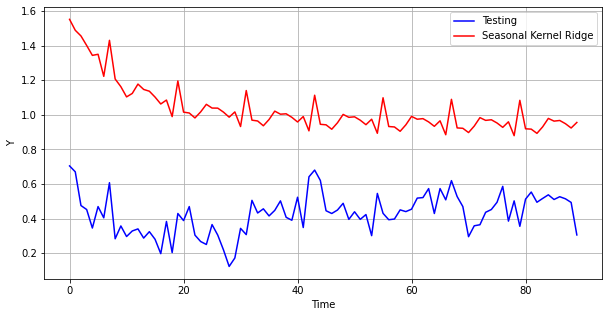

In [15]:
plot_predictions(data[1], y_skr, "Seasonal Kernel Ridge")

## Support Vector Machine

In [16]:
svr = TimeSeriesForecaster(LinearSVR(dual=False, loss="squared_epsilon_insensitive"), window_length=period, detrend=detrend)
svr.fit(data[0])
y_svr = svr.predict(len(data[1]))

ssvr = TimeSeriesForecaster(
    LinearSVR(dual=False, loss="squared_epsilon_insensitive"), window_length=period, detrend=detrend, period=period)
ssvr.fit(data[0])
y_ssvr = ssvr.predict(len(data[1]))

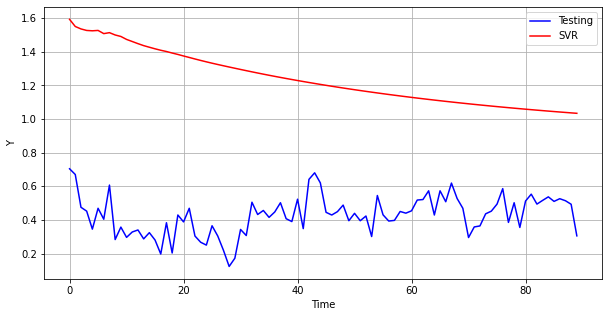

In [17]:
plot_predictions(data[1], y_svr, "SVR")

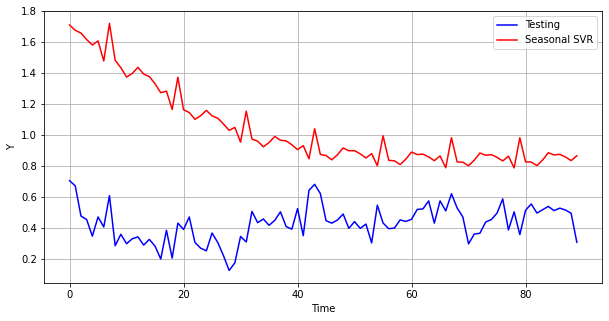

In [18]:
plot_predictions(data[1], y_ssvr, "Seasonal SVR")

## Kernel Support Vector Machine

In [19]:
ksvr = TimeSeriesForecaster(SVR(), window_length=period, detrend=detrend)
ksvr.fit(data[0])
y_ksvr = ksvr.predict(len(data[1]))

sksvr = TimeSeriesForecaster(SVR(), window_length=period, detrend=detrend, period=period)
sksvr.fit(data[0])
y_sksvr = sksvr.predict(len(data[1]))

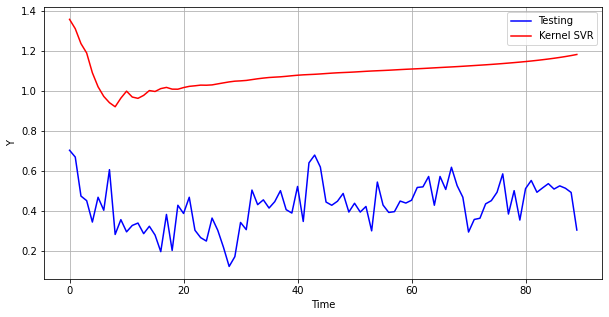

In [20]:
plot_predictions(data[1], y_ksvr, "Kernel SVR")

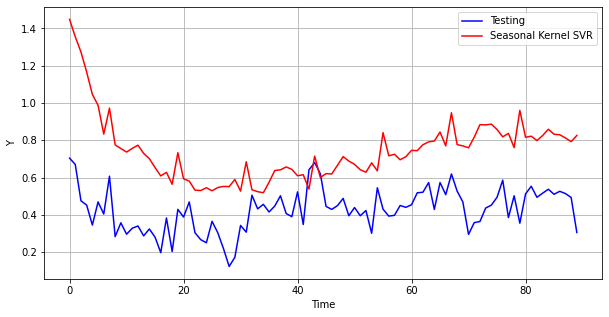

In [21]:
plot_predictions(data[1], y_sksvr, "Seasonal Kernel SVR")

## Model Evaluation

In [22]:
maes = np.array([
    mean_absolute_error(data[1], y_br), mean_absolute_error(data[1], y_sbr), mean_absolute_error(data[1], y_kr),
    mean_absolute_error(data[1], y_skr), mean_absolute_error(data[1], y_svr), mean_absolute_error(data[1], y_ssvr),
    mean_absolute_error(data[1], y_ksvr), mean_absolute_error(data[1], y_sksvr)
])

pocids = np.array([
    pocid(data[1], y_br), pocid(data[1], y_sbr), pocid(data[1], y_kr), pocid(data[1], y_skr),
    pocid(data[1], y_svr), pocid(data[1], y_ssvr), pocid(data[1], y_ksvr), pocid(data[1], y_sksvr)
])

tu_naive = maes / mean_absolute_error(data[1], y_naive)
tu_snaive = maes / mean_absolute_error(data[1], y_snaive)

error_table = {
    "model" : [
        "Bayesian Ridge", "Seasonal Bayesian Ridge", "Kernel Ridge", "Seasonal Kernel Ridge",
        "SVR", "Seasonal SVR", "Kernel SVR", "Seasonal Kernel SVR"],
    "TU-naive" : tu_naive,
    "TU-snaive" : tu_snaive,
    "POCID" : pocids
}

df = pd.DataFrame(error_table)
df = df.set_index("model")
df["MC"] = [multi_criteria(df.loc[i,:]) for i in df.index]
df

,TU-naive,TU-snaive,POCID,MC
model,,,,
Bayesian Ridge,1.234010,1.600279,0.522222,1.441465
Seasonal Bayesian Ridge,2.788978,3.616780,0.622222,5.415721
Kernel Ridge,3.167388,4.107506,0.500000,7.208585
Seasonal Kernel Ridge,2.808957,3.642689,0.611111,5.517071
SVR,3.782398,4.905059,0.522222,9.830929
Seasonal SVR,2.849885,3.695765,0.622222,5.631462
Kernel SVR,3.085297,4.001050,0.533333,6.777251
Seasonal Kernel SVR,1.487496,1.929002,0.588889,1.850672
